Group 20 members:
- Manuel Weiss:           weissman@students.zhaw.ch
- Janick Michot:          michojan@students.zhaw.ch
- Andre von Aarburg :     andre.vonaarburg@ost.ch
- Severin Weiss:          severin.weiss@ost.ch

# CNN from CIFAR10 raw data using Keras
Modify your MLP version from the previous exercise towards Convolutional Neural Networks.

## 1. Exercise description

### Simple CNN

Start with the following configuration :

- Keep your input shape equals to (32x32x3), i.e. you don’t need to reshape your input into a flattened vector. A given training sample Xi will hold the raw pixel values of the ith image of width 32, height 32, and with three color channels R,G,B.
- Insert a first convolutional layer Conv2D() with 32 filters and stride S = 1. With Keras or Pytorch, you can let it compute the padding using the option padding=’same’ in the arguments of the layer. This layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This will result in an output volume (32x32x32) as we decided to use 32 filters.
- Insert a ReLU layer that will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged (32x32x32).
- Insert a 2D max pooling layer of size 2. This layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in a volume (16x16x32).
- CNN usually ends with a fully-connected (dense) layer that will compute the class scores, resulting in a volume of size (1x1x10), where each of the 10 numbers correspond to a class score. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the values in the previous volume. For this reason, in Keras, you first need to “flatten” the output volume of the previous layer, in our case from (16,16,32) towards (1,8192). To do that use re-shaping layer to flatten the values. You may finally plug the dense layer with a softmax activation.

Already with this simple CNN, you should observe a gain in your performance of about 10% against your best MLP version of the previous exercise.


### Deeper CNN

From the previous CNN network, investigate with deeper architectures adding couples of 2D convolutional and layers. A rule of thumb is to try to extract higher level information going deeper in the network, therefore increasing the number of filters and the size of the kernel could be a good idea.

**Hint** : When going deeper, you may need to activate batch normalisations. You will see the theory on such layer soon in the class. It takes the form of normalisation layers called BatchNormalisation() that need to be inserted in between the Conv2D and the ReLu acti- vation layers.

Report on your experiments and describe your best configuration through experimenting with 3-5 different architectures. Use a table similar to the example given below and provides the hyper-parameters used for your configurations.

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses, utils, models, regularizers
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from KerasConfigService import KerasConfigService

In [2]:
from KerasConfigService import KerasConfigService

## 2. Data loading and preparation
This section encompasses the data loading, gives a short preview of the data and prepares the data so that it fits as input for the CNN.

In [3]:

# Load data & split data between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("Type X_train: ", type(x_train.shape))
print("Shape X_train: ", x_train.shape)
print("Shape y_train: ", y_train.shape)
print("Shape X_test: ", x_test.shape)
print("Shape y_test: ", y_test.shape)

Type X_train:  <class 'tuple'>
Shape X_train:  (50000, 32, 32, 3)
Shape y_train:  (50000, 1)
Shape X_test:  (10000, 32, 32, 3)
Shape y_test:  (10000, 1)


In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
def show_images(x, y, class_labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i])
        plt.xlabel(class_labels[y[i].item()], color="red")
    plt.show()

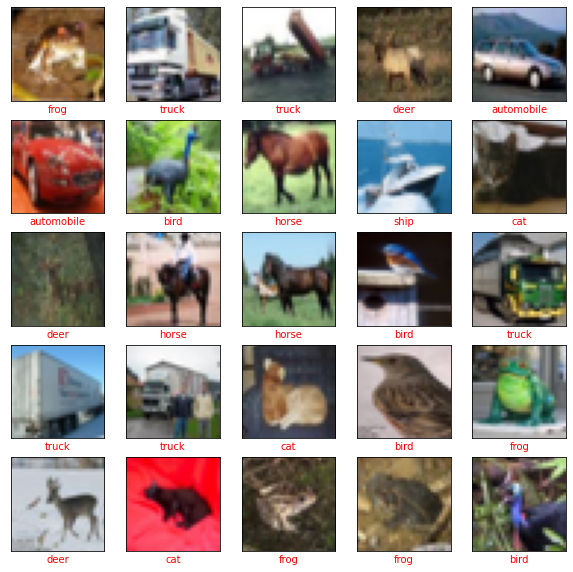

In [6]:
show_images(x_train, y_train, classes)

### Show distribution of classes
Seems that the classes are equally distributed.

/Users/manuel/Documents/MSE_Projects/deep_learning/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')]]

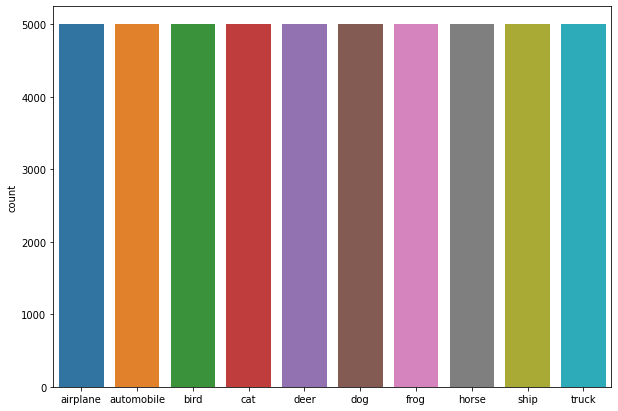

In [7]:
plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

### Transforming and preparing data
1. Cast type to float
2. normalizing values

In [8]:
x_train =  x_train.astype('float32')   # change the type towards float32
x_test =   x_test.astype('float32')    # idem
x_train /= 255                         # normalize the range to be between 0.0 and 1.0
x_test /=  255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


### One-hot encoding of labels (ground truths)

1. y_train
2. y_test

In [9]:
# number of classes in train test labels
num_classes = len(set(y_train.flatten()))

print("Num classes:", num_classes, "\n")

print("Before one hot encoding:", y_train[0])

y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

print("After one hot encoding:", y_train[0])

Num classes: 10 

Before one hot encoding: [6]
After one hot encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Part 1: Simple CNN
### Shallow network configs

In [10]:
batch_size: int=128
epochs: int=15
num_filters: int=32
kernel_size: tuple = (3, 3)
strides: tuple=(1, 1)
padding='same'
input_shape=x_train.shape[1:]
pool_size: tuple = (2, 2)

### Defining the model

In [11]:
model = models.Sequential()

model.add(layers.Conv2D(num_filters, kernel_size, strides=strides, padding=padding, input_shape=input_shape))
model.add(layers.ReLU())
model.add(layers.MaxPool2D(pool_size=pool_size))
model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 re_lu (ReLU)                (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 10)                81930     
                                                                 
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
____________________________________________________

2022-04-04 17:33:56.849962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compiling the model

In [12]:
model.compile(optimizer='rmsprop', loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])

### Fitting the model

In [13]:
logs = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Epoch 1/15
352/352 [==============================] - 10s 28ms/step - loss: 1.6765 - accuracy: 0.4114 - val_loss: 1.6398 - val_accuracy: 0.3946
Epoch 2/15
352/352 [==============================] - 10s 28ms/step - loss: 1.3689 - accuracy: 0.5262 - val_loss: 1.3209 - val_accuracy: 0.5534
Epoch 3/15
352/352 [==============================] - 10s 28ms/step - loss: 1.2567 - accuracy: 0.5640 - val_loss: 1.2655 - val_accuracy: 0.5646
Epoch 4/15
352/352 [==============================] - 10s 28ms/step - loss: 1.1866 - accuracy: 0.5891 - val_loss: 1.2865 - val_accuracy: 0.5412
Epoch 5/15
352/352 [==============================] - 10s 28ms/step - loss: 1.1385 - accuracy: 0.6059 - val_loss: 1.1911 - val_accuracy: 0.5898
Epoch 6/15
352/352 [==============================] - 10s 28ms/step - loss: 1.0944 - accuracy: 0.6225 - val_loss: 1.1812 - val_accuracy: 0.5942
Epoch 7/15
352/352 [==============================] - 10s 28ms/step - loss: 1.0557 - accuracy: 0.6365 - val_loss: 1.1041 - val_accuracy:

### Investigating logs and model object

In [14]:
# investigating history object

print("Logs:")
print(type(logs))
print(type(logs.history))
print(logs.history.keys())
print(logs.history.keys())
print(logs.params, "\n")

print("Model:")
print(model.get_config().keys(), "\n")
print(model.get_config(), "\n")

Logs:
<class 'keras.callbacks.History'>
<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'verbose': 1, 'epochs': 15, 'steps': 352} 

Model:
dict_keys(['name', 'layers']) 

{'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'k

In [15]:
def plot_history(logs, title="", accuracy=True, loss=True, combined=True):
    print(title)

    num_charts = np.array([accuracy, loss, combined]).sum()

    if num_charts == 0:
        return

    chart_idx = 0
    fig = plt.figure(figsize=(num_charts * 10, 8))

    if accuracy:
        chart_idx +=1
        ax1 = fig.add_subplot(1, num_charts, chart_idx)
        ax1.set_title("Loss")
        ax1.set_xlabel("epochs")
        ax1.set_ylabel("loss")
        ax1.plot(logs.history['val_loss'], color='b', linestyle='-', label='Validation Loss')
        ax1.plot(logs.history['loss'], color='lightblue', linestyle='--', label='Training Loss')
        ax1.legend()

    if logs:
        chart_idx +=1
        ax2 = fig.add_subplot(1, num_charts, chart_idx)
        ax2.set_title("Accuracy")
        ax2.set_xlabel("epochs")
        ax2.set_ylabel("accuracy")
        ax2.plot(logs.history['val_accuracy'], color='r', linestyle='-', label='Validation Accuracy')
        ax2.plot(logs.history['accuracy'], color='orange', linestyle='--', label='Training Accuracy')
        ax2.legend()

    if combined:
        chart_idx +=1
        ax3 = fig.add_subplot(1, num_charts, chart_idx)
        ax3.set_title("Combined")
        ax3.set_xlabel("epochs")
        ax3.set_ylabel("accuracy / loss")
        ax3.plot(logs.history['val_loss'], color='b', linestyle='-', label='Validation Loss')
        ax3.plot(logs.history['loss'], color='lightblue', linestyle='--', label='Training Loss')
        ax3.plot(logs.history['val_accuracy'], color='r', linestyle='-', label='Validation Accuracy')
        ax3.plot(logs.history['accuracy'], color='orange', linestyle='--', label='Training Accuracy')
        ax3.legend()

    plt.show()

### Plotting result of shallow network

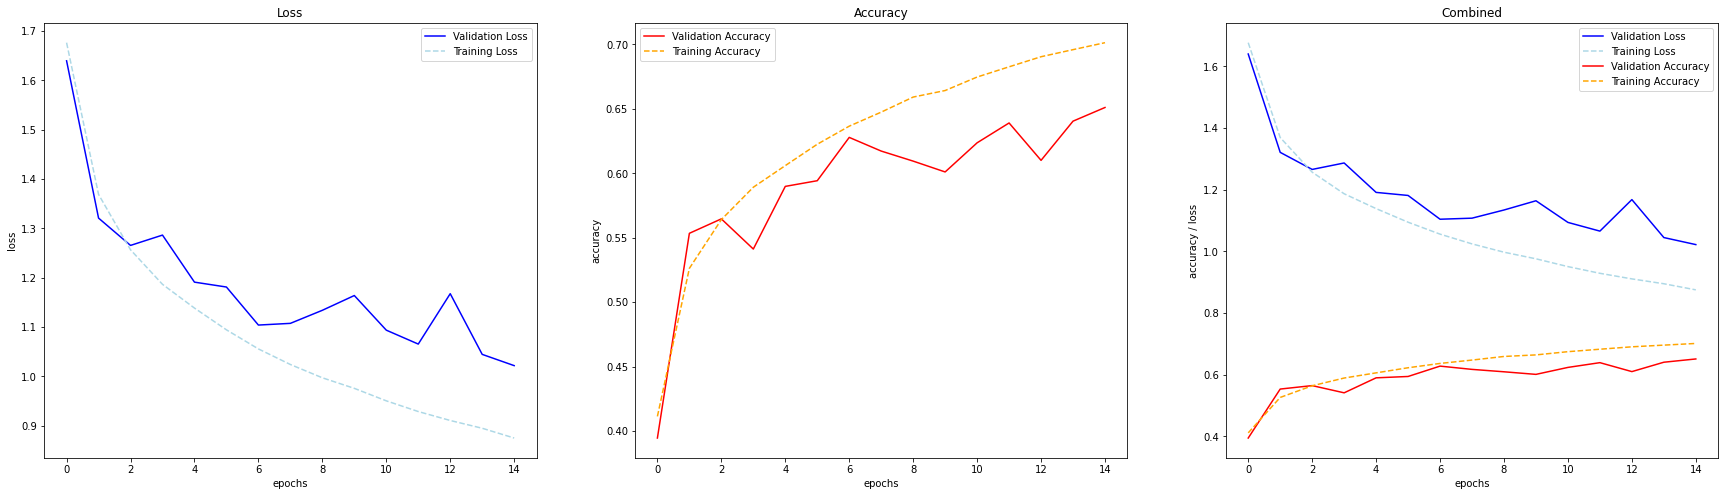

In [16]:
plot_history(logs)

### Evaluate test set with confusion matrix

In [17]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test-set evaluation: Accuracy -> {round(test_acc * 100)}%, Loss -> {round(test_loss, 2)}")

313/313 [==============================] - 1s 2ms/step - loss: 1.0443 - accuracy: 0.6408
Test-set evaluation: Accuracy -> 64%, Loss -> 1.04


[[Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')],
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')],
 Text(0.5, 69.0, 'prediction'),
 Text(69.0, 0.5, 'ground truth')]

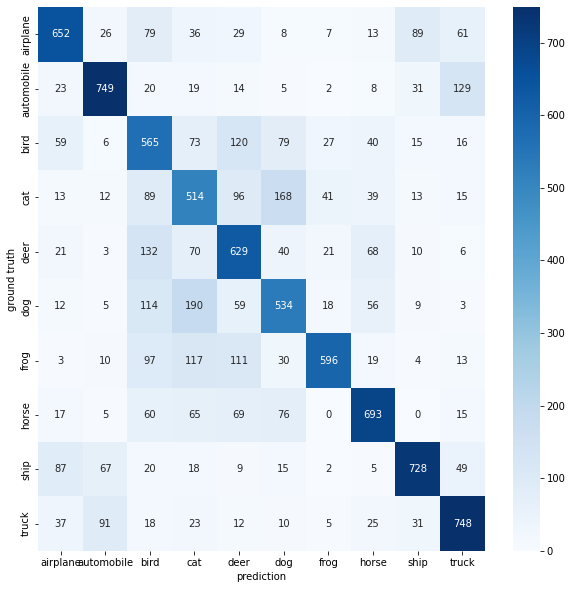

In [18]:
# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

fig = plt.figure(figsize=(10,10))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap="Blues")
c.set(xticklabels=classes, yticklabels=classes, xlabel="prediction", ylabel='ground truth')

## Part 2: Deeper CNNs

In [19]:
def create_sequence(filters, kernel_size, strides, pool_size, weight_decay, input_shape):
    model = models.Sequential()
    for idx in num_conv_sequences:
        model.add(layers.Conv2D(filters * (idx+1), kernel_size, strides, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape if idx == 0 else []))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Conv2D(filters * (idx+1), kernel_size, strides, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.MaxPool2D(pool_size=pool_size))
        model.add(layers.Dropout(0.2 + idx * 0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [20]:
result_df = pd.DataFrame(columns=['CNN', 'Architecture', 'epochs', 'Acc. train %', 'Acc. valid %', 'Acc. test %'])

num_conv_sequences = np.arange(3)

batch_size: int=128
epochs: int=30
num_filters: list[int]=[32, 42]
kernel_sizes: list[tuple[int, int]] = [(2, 2), (3, 3), (5, 5)]
strides: tuple[int, int]=(1, 1)
padding: str='same'
input_shape=x_train.shape[1:]
pool_size: tuple[int, int] = (2, 2)
weight_decay: float = 1e-4

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        416       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 32, 32, 32)       

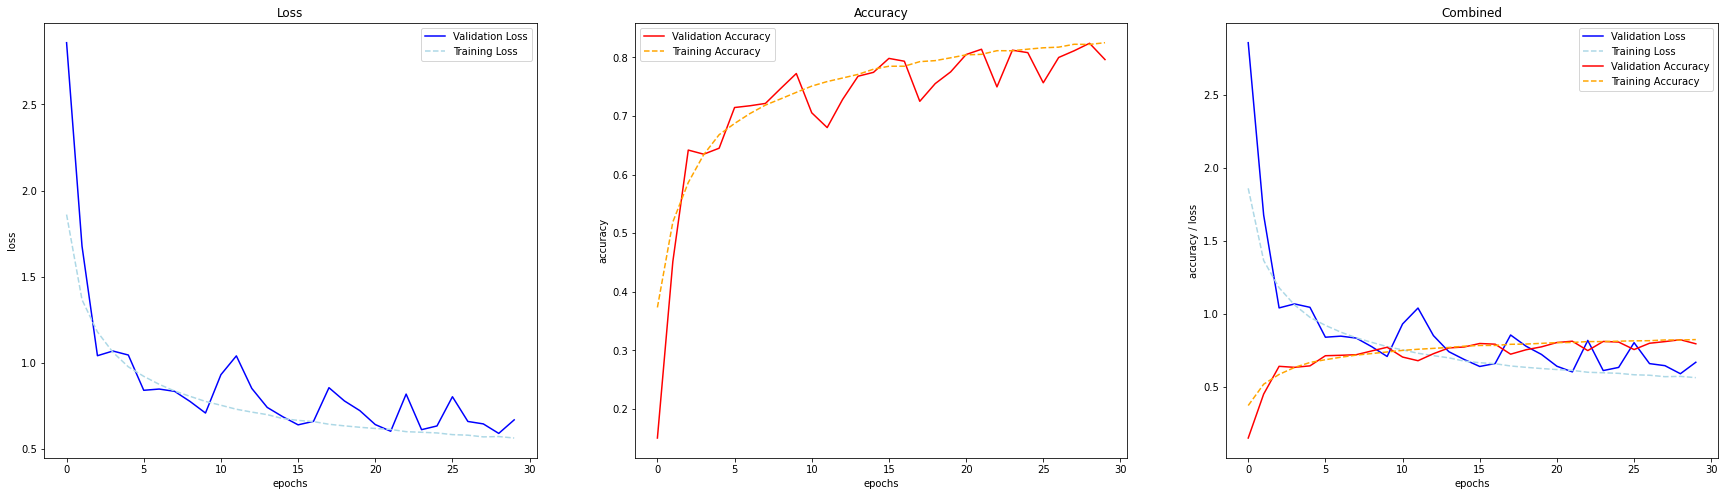

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 32, 32, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_8 (ReLU)              (None, 32, 32, 32)       

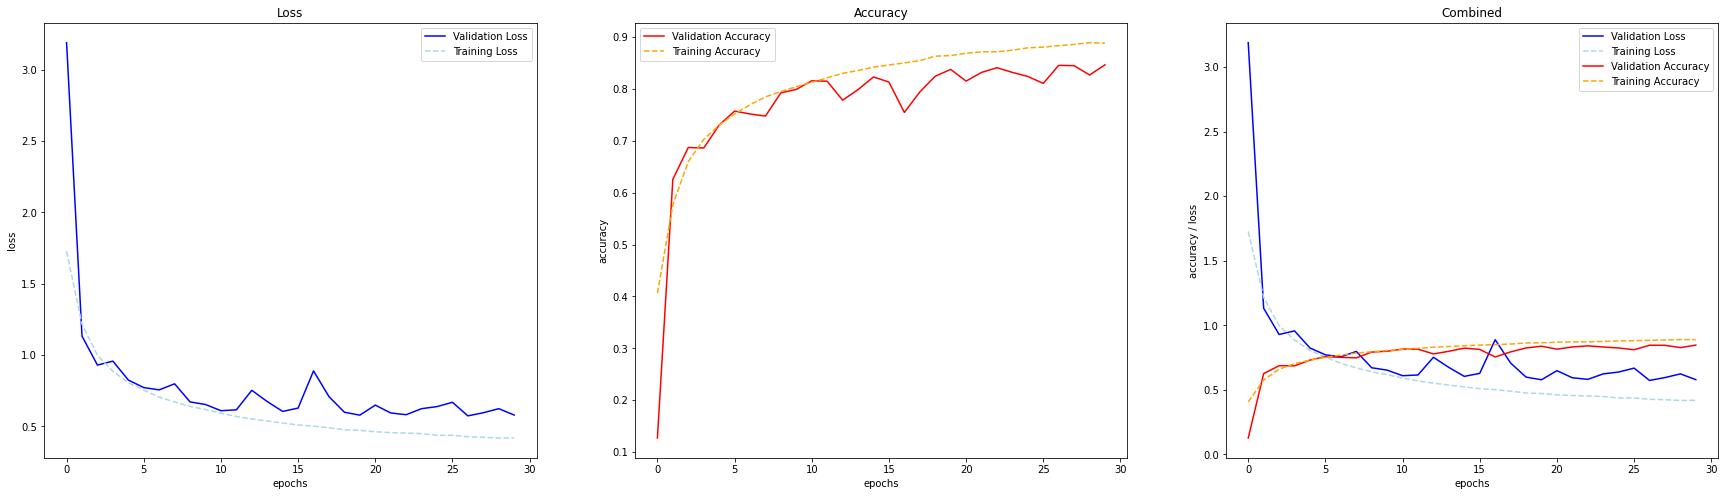

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 re_lu_13 (ReLU)             (None, 32, 32, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 re_lu_14 (ReLU)             (None, 32, 32, 32)       

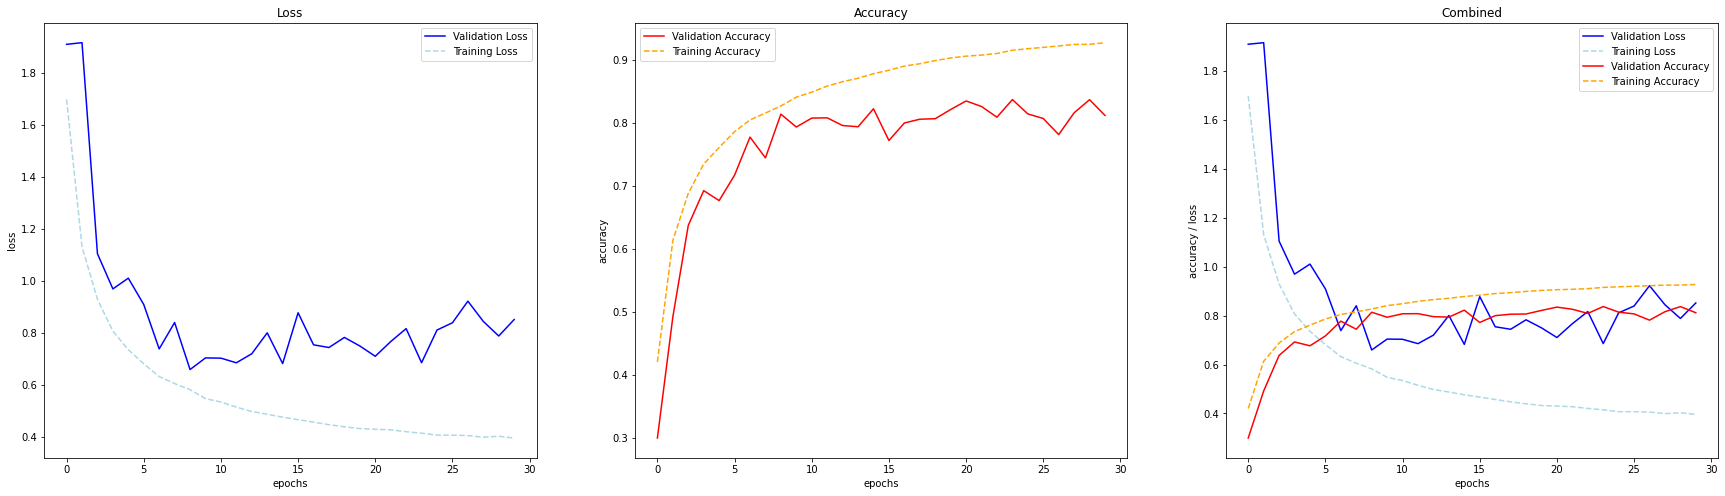

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 42)        546       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 42)       168       
 chNormalization)                                                
                                                                 
 re_lu_19 (ReLU)             (None, 32, 32, 42)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 42)        7098      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 42)       168       
 chNormalization)                                                
                                                                 
 re_lu_20 (ReLU)             (None, 32, 32, 42)       

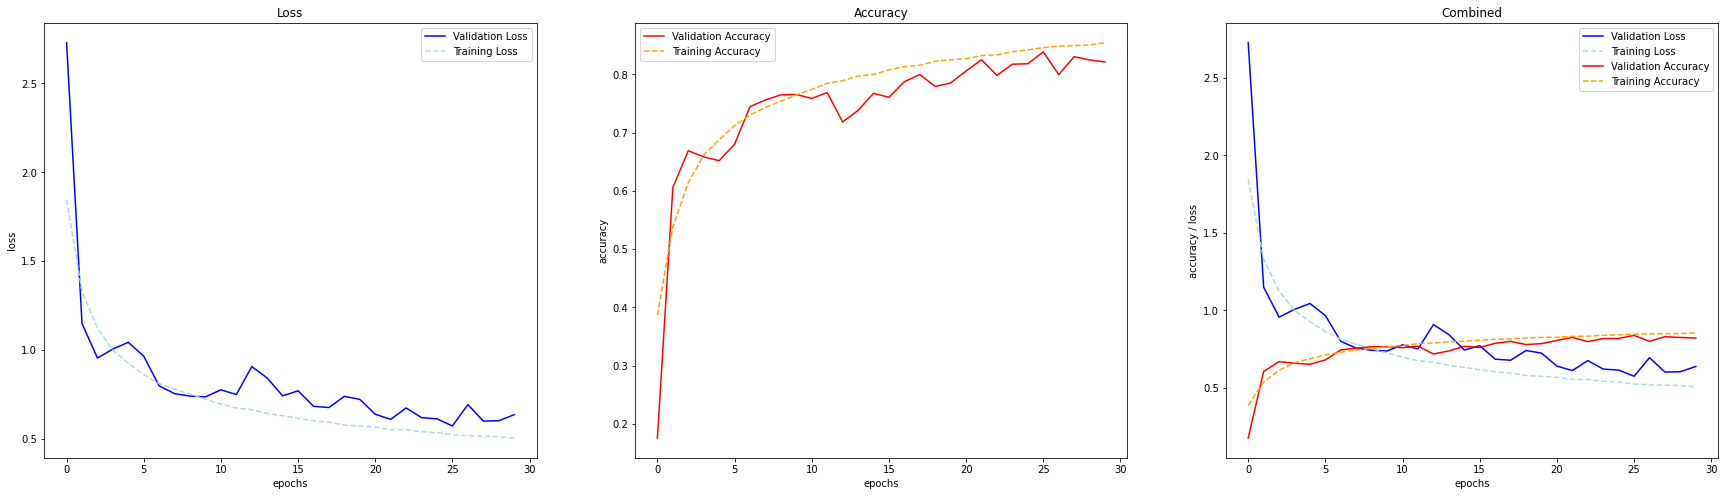

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 42)        1176      
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 42)       168       
 chNormalization)                                                
                                                                 
 re_lu_25 (ReLU)             (None, 32, 32, 42)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 42)        15918     
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 42)       168       
 chNormalization)                                                
                                                                 
 re_lu_26 (ReLU)             (None, 32, 32, 42)       

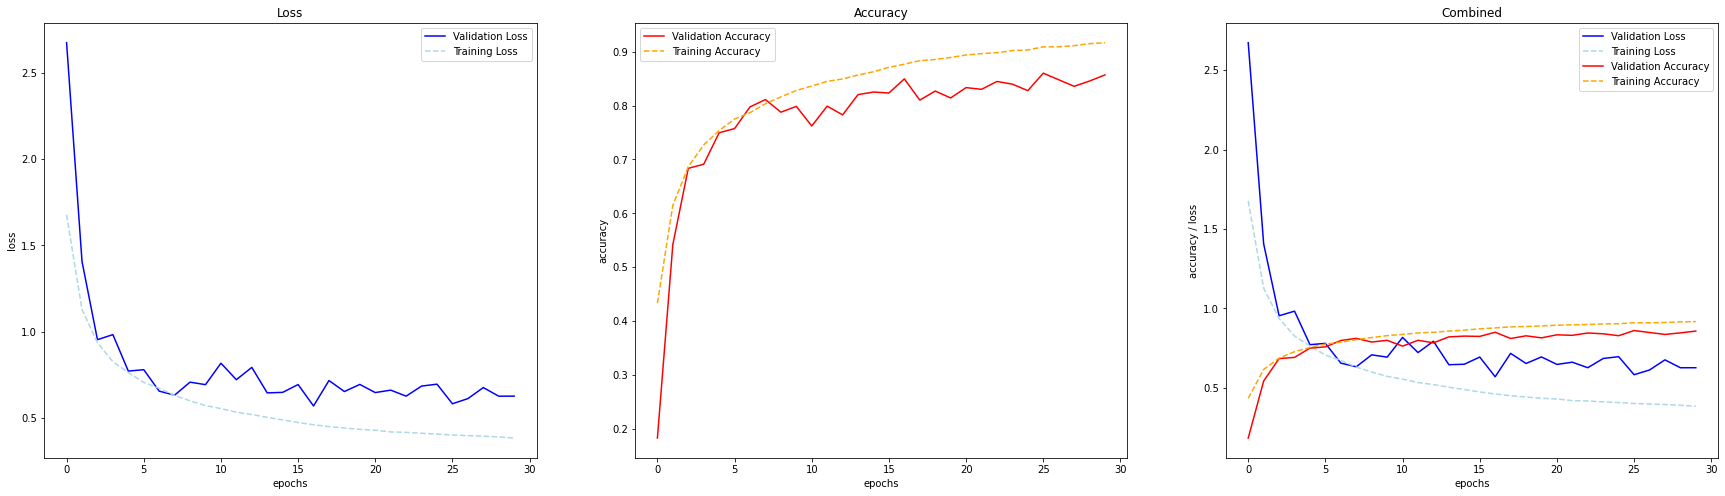

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 42)        3192      
                                                                 
 batch_normalization_30 (Bat  (None, 32, 32, 42)       168       
 chNormalization)                                                
                                                                 
 re_lu_31 (ReLU)             (None, 32, 32, 42)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 42)        44142     
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 42)       168       
 chNormalization)                                                
                                                                 
 re_lu_32 (ReLU)             (None, 32, 32, 42)       

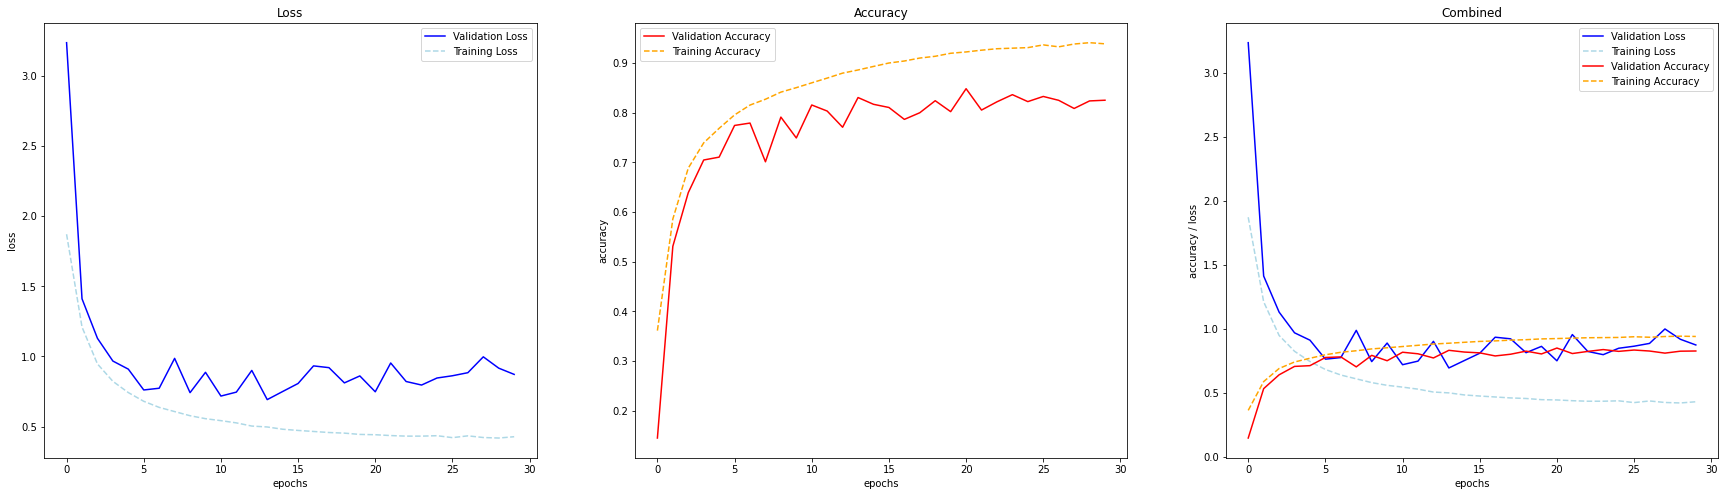

In [21]:
for filters in num_filters:
    for kernel_size in kernel_sizes:

        # creating the model by configs
        model = create_sequence(filters, kernel_size, strides, pool_size, weight_decay, input_shape)
        print(model.summary())

        # compiling and training the model
        model.compile(optimizer='adam', loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
        logs = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

        # evaluate test accuracy
        loss_test, accuracy_test = model.evaluate(x_test, y_test)

        # saving the results
        display_configs = ['class_name', {'config': ['kernel_size', 'strides', 'filters', 'rate', 'units']}]
        config_string = KerasConfigService.to_string(model, include_configs=display_configs)
        plot_title = KerasConfigService.to_string(model, include_configs=display_configs, line_breaks=True)

        epochs = logs.params['epochs']

        accuracy_train_hist = logs.history['accuracy']
        accuracy_train = accuracy_train_hist[len(accuracy_train_hist) - 1]

        accuracy_valid_hist = logs.history['val_accuracy']
        accuracy_valid = accuracy_valid_hist[len(accuracy_train_hist) - 1]

        result_df.loc[len(result_df.index)] = [1, config_string, logs.params['epochs'],round(accuracy_train, 3) * 100, round(accuracy_valid, 3) * 100, round(accuracy_test, 3) * 100]
        plot_history(logs, plot_title)

### Architecture result table

In [28]:
# displaying the results
display(result_df)

,CNN,Architecture,epochs,Acc. train %,Acc. valid %,Acc. test %
0,1,"Layer 1: class_name: InputLayer; Layer 2: class_name: Conv2D config:{ kernel_size: (2, 2) strides: (1, 1) filters: 32 }; Layer 3: class_name: BatchNormalization; Layer 4: class_name: ReLU; Layer 5: class_name: Conv2D config:{ kernel_size: (2, 2) strides: (1, 1) filters: 32 }; Layer 6: class_name: BatchNormalization; Layer 7: class_name: ReLU; Layer 8: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 9: class_name: Dropout config:{ rate: 0.2 }; Layer 10: class_name: Conv2D config:{ kernel_size: (2, 2) strides: (1, 1) filters: 64 }; Layer 11: class_name: BatchNormalization; Layer 12: class_name: ReLU; Layer 13: class_name: Conv2D config:{ kernel_size: (2, 2) strides: (1, 1) filters: 64 }; Layer 14: class_name: BatchNormalization; Layer 15: class_name: ReLU; Layer 16: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 17: class_name: Dropout config:{ rate: 0.30000000000000004 }; Layer 18: class_name: Conv2D config:{ kernel_size: (2, 2) strides: (1, 1) filters: 96 }; Layer 19: class_name: BatchNormalization; Layer 20: class_name: ReLU; Layer 21: class_name: Conv2D config:{ kernel_size: (2, 2) strides: (1, 1) filters: 96 }; Layer 22: class_name: BatchNormalization; Layer 23: class_name: ReLU; Layer 24: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 25: class_name: Dropout config:{ rate: 0.4 }; Layer 26: class_name: Flatten; Layer 27: class_name: Dense config:{ units: 10 };",30,82.5,79.6,78.3
1,1,"Layer 1: class_name: InputLayer; Layer 2: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 32 }; Layer 3: class_name: BatchNormalization; Layer 4: class_name: ReLU; Layer 5: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 32 }; Layer 6: class_name: BatchNormalization; Layer 7: class_name: ReLU; Layer 8: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 9: class_name: Dropout config:{ rate: 0.2 }; Layer 10: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 64 }; Layer 11: class_name: BatchNormalization; Layer 12: class_name: ReLU; Layer 13: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 64 }; Layer 14: class_name: BatchNormalization; Layer 15: class_name: ReLU; Layer 16: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 17: class_name: Dropout config:{ rate: 0.30000000000000004 }; Layer 18: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 96 }; Layer 19: class_name: BatchNormalization; Layer 20: class_name: ReLU; Layer 21: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 96 }; Layer 22: class_name: BatchNormalization; Layer 23: class_name: ReLU; Layer 24: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 25: class_name: Dropout config:{ rate: 0.4 }; Layer 26: class_name: Flatten; Layer 27: class_name: Dense config:{ units: 10 };",30,88.8,84.7,83.4
2,1,"Layer 1: class_name: InputLayer; Layer 2: class_name: Conv2D config:{ kernel_size: (5, 5) strides: (1, 1) filters: 32 }; Layer 3: class_name: BatchNormalization; Layer 4: class_name: ReLU; Layer 5: class_name: Conv2D config:{ kernel_size: (5, 5) strides: (1, 1) filters: 32 }; Layer 6: class_name: BatchNormalization; Layer 7: class_name: ReLU; Layer 8: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 9: class_name: Dropout config:{ rate: 0.2 }; Layer 10: class_name: Conv2D config:{ kernel_size: (5, 5) strides: (1, 1) filters: 64 }; Layer 11: class_name: BatchNormalization; Layer 12: class_name: ReLU; Layer 13: class_name: Conv2D config:{ kernel_size: (5, 5) strides: (1, 1) filters: 64 }; Layer 14: class_name: BatchNormalization; Layer 15: class_name: ReLU; Layer 16: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 17: class_name: Dropout config:{ rate: 0.30000000000000004 }; Layer 18: class_name: Conv2D config:{ kernel_size: (5, 5) strides: (1, 1) filters: 96 }; Layer 19: class_name: BatchNormalization; Laye

### Best result
As we can see in the results of the architecture result table, we obtained the best result of 84.5 on the training set with the following configurations:

---

#### Configuration elements

`class_name, kernel_size, strides, filters, rate, units`

---

#### Configuration

Summary: Kernel size: (3, 3), Filters: 42

Layer 1: class_name: InputLayer; Layer 2: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 42 }; Layer 3: class_name: BatchNormalization; Layer 4: class_name: ReLU; Layer 5: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 42 }; Layer 6: class_name: BatchNormalization; Layer 7: class_name: ReLU; Layer 8: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 9: class_name: Dropout config:{ rate: 0.2 }; Layer 10: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 84 }; Layer 11: class_name: BatchNormalization; Layer 12: class_name: ReLU; Layer 13: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 84 }; Layer 14: class_name: BatchNormalization; Layer 15: class_name: ReLU; Layer 16: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 17: class_name: Dropout config:{ rate: 0.30000000000000004 }; Layer 18: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 126 }; Layer 19: class_name: BatchNormalization; Layer 20: class_name: ReLU; Layer 21: class_name: Conv2D config:{ kernel_size: (3, 3) strides: (1, 1) filters: 126 }; Layer 22: class_name: BatchNormalization; Layer 23: class_name: ReLU; Layer 24: class_name: MaxPooling2D config:{ strides: (2, 2) }; Layer 25: class_name: Dropout config:{ rate: 0.4 }; Layer 26: class_name: Flatten; Layer 27: class_name: Dense config:{ units: 10 };

---

#### 2. Best
A quite similar good result we obtained with a the following configurations:
Summary: Kernel size: (3, 3), Filters: 42

